In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# LOAD DATA


NOTE: SS_cons symbols can be looked up in the infernal dokumentation

definition block:  bunch of adjacent < or > in the structure, now adding all other stems and a counter 

len + lennogap ,count   ,, length of alignments sometimes removing gaps, number of sequences in the alignment

aliX , ali1, ali2 , removing badly aligned sequences: 20%, 1 ,2   
calculation: rank sequences by outlier-points: if a column has 1 '.', or all but 1 '.' count an outlier-point

filtered: removing blocks of ~size~ len <3

flank: selected the positions that are within 5nuc of a block

cons, cov:  
calculation: mean([(max(Y,R)> .5 and (number of dots) else 0) / count])  
calculation: mean([(max(character) / count] and . becomes 0)  
calculation: cov/len 

stem length last-1: size of the second largest block 




In [2]:
debug = True

from sklearn.model_selection import train_test_split
import loadfiles
p,n  = loadfiles.loaddata("data",numneg=3000 if not debug else 200, pos='1' if debug else 'both', seed = 9)

['219-16580-0-1.sto', '647-7921-0-0.sto', '550-386641-0-0.sto', '94-5443-0-1.sto', '480-8527-0-0.sto']
loadfiles.py: removing some positives


# Make a pandas dataframe, 

In [3]:
import pandas as pd
import copy

def clean(di,oklist):
    for k in list(di.keys()):
        if k not in oklist:
            di.pop(k)
    return di

def makeXY(featurelist):
    asd = [ clean(e,featurelist) for e in copy.deepcopy(p+n) ]
    df = pd.DataFrame(asd)
    X= df.to_numpy()
    y= [1]*len(p)+[0]*len(n)
    return X,y,df


allfeatures = list(p[1].keys()) # the filenames are the last one and we dont need that (for now)
allfeatures.remove("name")
X,Y,df = makeXY(allfeatures)

# check if is nan
from IPython.display import display, HTML
display(HTML(df[df.isna().any(axis=1)].head().to_html()))

,total conservation,total conservation +cov,total conservation_nuc,total conservation_nuc +cov,number of < blocks,number of ( blocks,number of [ blocks,number of { blocks,stem length smallest,stem length last-1,stem length max,stem cons,stem cons nuc,flank cons,flank cons nuc,perc stem,length,count,stem covariance,sloppy gu,sloppy all,allblockXalitotal conservation,allblockXalitotal conservation +cov,allblockXalitotal conservation_nuc,allblockXalitotal conservation_nuc +cov,allblockXali number of < blocks,allblockXali number of ( blocks,allblockXali number of [ blocks,allblockXali number of { blocks,allblockXali stem length smallest,allblockXali stem length last-1,allblockXali stem length max,allblockXali stem cons,allblockXali stem cons nuc,allblockXali flank cons,allblockXali flank cons nuc,allblockXaliperc stem,allblockXali length,allblockXali count,allblockXali stem covariance,allblockXali sloppy gu,allblockXali sloppy all,allblock1alitotal conservation,allblock1alitotal conservation +cov,allblock1alitotal conservation_nuc,allblock1alitotal conservation_nuc +cov,allblock1ali number of < blocks,allblock1ali number of ( blocks,allblock1ali number of [ blocks,allblock1ali number of { blocks,allblock1ali stem length smallest,allblock1ali stem length last-1,allblock1ali stem length max,allblock1ali stem cons,allblock1ali stem cons nuc,allblock1ali flank cons,allblock1ali flank cons nuc,allblock1aliperc stem,allblock1ali length,allblock1ali count,allblock1ali stem covariance,allblock1ali sloppy gu,allblock1ali sloppy all,allblock2alitotal conservation,allblock2alitotal conservation +cov,allblock2alitotal conservation_nuc,allblock2alitotal conservation_nuc +cov,allblock2ali number of < blocks,allblock2ali number of ( blocks,allblock2ali number of [ blocks,allblock2ali number of { blocks,allblock2ali stem length smallest,allblock2ali stem length last-1,allblock2ali stem length max,allblock2ali stem cons,allblock2ali stem cons nuc,allblock2ali flank cons,allblock2ali flank cons nuc,allblock2aliperc stem,allblock2ali length,allblock2ali count,allblock2ali stem covariance,allblock2ali sloppy gu,allblock2ali sloppy all,delblockalitotal conservation,delblockalitotal conservation +cov,delblockalitotal conservation_nuc,delblockalitotal conservation_nuc +cov,delblockali number of < blocks,delblockali number of ( blocks,delblockali number of [ blocks,delblockali number of { blocks,delblockali stem length smallest,delblockali stem length last-1,delblockali stem length max,delblockali stem cons,delblockali stem cons nuc,delblockali flank cons,delblockali flank cons nuc,delblockaliperc stem,delblockali length,delblockali count,delblockali stem covariance,delblockali sloppy gu,delblockali sloppy all,delblockXalitotal conservation,delblockXalitotal conservation +cov,delblockXalitotal conservation_nuc,delblockXalitotal conservation_nuc +cov,delblockXali number of < blocks,delblockXali number of ( blocks,delblockXali number of [ blocks,delblockXali number of { blocks,delblockXali stem length smallest,delblockXali stem length last-1,delblockXali stem length max,delblockXali stem cons,delblockXali stem cons nuc,delblockXali flank cons,delblockXali flank cons nuc,delblockXaliperc stem,delblockXali length,delblockXali count,delblockXali stem covariance,delblockXali sloppy gu,delblockXali sloppy all,delblock1alitotal conservation,delblock1alitotal conservation +cov,delblock1alitotal conservation_nuc,delblock1alitotal conservation_nuc +cov,delblock1ali number of < blocks,delblock1ali number of ( blocks,delblock1ali number of [ blocks,delblock1ali number of { blocks,delblock1ali stem length smallest,delblock1ali stem length last-1,delblock1ali stem length max,delblock1ali stem cons,delblock1ali stem cons nuc,delblock1ali flank cons,delblock1ali flank cons nuc,delblock1aliperc stem,delblock1ali length,delblock1ali count,delblock1ali stem covariance,delblock1ali sloppy gu,delblock1ali sloppy all,delblock2alitotal conservation,delblock2alitotal conservatio

# feature selection 

In [4]:
%%time
from sklearn.feature_selection import RFECV as rec
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest
import pandas as pd
X = StandardScaler().fit_transform(X)
from sklearn.linear_model import Lasso
from skrebate import ReliefF as relief
from sklearn.metrics import f1_score
from sklearn.svm import SVC


randseed = 42
testsize=.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=randseed) # USE THE SAME SEED AS BELOW! 


def scorer(esti,x,y):
    yh = esti.predict(x)
    return f1_score(y,yh)

def lasso(X_data,y_data,alpha=.06):
    mod = Lasso(alpha=alpha)
    mod.fit(X_data,y_data)
    return [b for a,b in zip(mod.coef_, df.columns) if a!=0]


reli=relief()
reli.fit(X_train,y_train)

def relief(_,_2,param):
    #https://github.com/EpistasisLab/scikit-rebate
    return [ df.columns[top] for top in reli.top_features_[:param]]


def variance_threshold(X_data, y_data, threshold=0.0):
    clf = VarianceThreshold(threshold)
    clf.fit(X_data, y_data)
    return [b for a,b in zip(clf.get_support(), df.columns) if a!=False]
    

def select_k_best(X_data, y_data, score_func=chi2, k=20):
    clf = SelectKBest(score_func, k)
    mini = 0
    for x in range(0, len(X_data)):
        mini = min(min(X_data[x]), mini)
    if mini < 0:
        for x in range(0, len(X_data)):
            for y in range(0, len(X_data[x])):
                X_data[x][y] -= mini
    clf.fit(X_data, y_data)
    return [b for a,b in zip(clf.get_support(), df.columns) if a!=False]


rfecv_estimator = SVC(kernel="linear")

def rfecv(X_data, y_data, estimator, step=1, cv=3):
    clf = rec(estimator, step, cv)
    clf.fit(X_data, y_data)
    return [b for a,b in zip(clf.get_support(), df.columns) if a!=False]


featurelists = [ selector(X_train,y_train) for selector in [ lambda x,y: lasso(x,y,alpha=.05),
                                                 lambda x,y: lasso(x,y,alpha=.01),
                                                 lambda x,y: relief(x,y,40),
                                                 lambda x,y: relief(x,y,60),
                                                 lambda x,y: relief(x,y,80),
                                                 lambda x,y: variance_threshold(x,y, threshold=1),
                                                 lambda x,y: select_k_best(x, y, k=20),
                                                 lambda x,y: rfecv(x, y, rfecv_estimator, step=1)
                                               ]]
featurelists.append(df.columns)
tmp =  pd.DataFrame([ [ 1 if f in featurelist else 0 for f in df.columns  ] for featurelist in featurelists],columns = df.columns)
display(HTML(tmp.loc[:, (tmp != 0).any(axis=0)].to_html()))

c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


,total conservation,total conservation +cov,total conservation_nuc,total conservation_nuc +cov,number of < blocks,number of ( blocks,number of [ blocks,number of { blocks,stem length smallest,stem length last-1,stem length max,stem cons,stem cons nuc,flank cons,flank cons nuc,perc stem,length,count,stem covariance,sloppy gu,sloppy all,allblockXalitotal conservation,allblockXalitotal conservation +cov,allblockXalitotal conservation_nuc,allblockXalitotal conservation_nuc +cov,allblockXali number of < blocks,allblockXali number of ( blocks,allblockXali number of [ blocks,allblockXali number of { blocks,allblockXali stem length smallest,allblockXali stem length last-1,allblockXali stem length max,allblockXali stem cons,allblockXali stem cons nuc,allblockXali flank cons,allblockXali flank cons nuc,allblockXaliperc stem,allblockXali length,allblockXali count,allblockXali stem covariance,allblockXali sloppy gu,allblockXali sloppy all,allblock1alitotal conservation,allblock1alitotal conservation +cov,allblock1alitotal conservation_nuc,allblock1alitotal conservation_nuc +cov,allblock1ali number of < blocks,allblock1ali number of ( blocks,allblock1ali number of [ blocks,allblock1ali number of { blocks,allblock1ali stem length smallest,allblock1ali stem length last-1,allblock1ali stem length max,allblock1ali stem cons,allblock1ali stem cons nuc,allblock1ali flank cons,allblock1ali flank cons nuc,allblock1aliperc stem,allblock1ali length,allblock1ali count,allblock1ali stem covariance,allblock1ali sloppy gu,allblock1ali sloppy all,allblock2alitotal conservation,allblock2alitotal conservation +cov,allblock2alitotal conservation_nuc,allblock2alitotal conservation_nuc +cov,allblock2ali number of < blocks,allblock2ali number of ( blocks,allblock2ali number of [ blocks,allblock2ali number of { blocks,allblock2ali stem length smallest,allblock2ali stem length last-1,allblock2ali stem length max,allblock2ali stem cons,allblock2ali stem cons nuc,allblock2ali flank cons,allblock2ali flank cons nuc,allblock2aliperc stem,allblock2ali length,allblock2ali count,allblock2ali stem covariance,allblock2ali sloppy gu,allblock2ali sloppy all,delblockalitotal conservation,delblockalitotal conservation +cov,delblockalitotal conservation_nuc,delblockalitotal conservation_nuc +cov,delblockali number of < blocks,delblockali number of ( blocks,delblockali number of [ blocks,delblockali number of { blocks,delblockali stem length smallest,delblockali stem length last-1,delblockali stem length max,delblockali stem cons,delblockali stem cons nuc,delblockali flank cons,delblockali flank cons nuc,delblockaliperc stem,delblockali length,delblockali count,delblockali stem covariance,delblockali sloppy gu,delblockali sloppy all,delblockXalitotal conservation,delblockXalitotal conservation +cov,delblockXalitotal conservation_nuc,delblockXalitotal conservation_nuc +cov,delblockXali number of < blocks,delblockXali number of ( blocks,delblockXali number of [ blocks,delblockXali number of { blocks,delblockXali stem length smallest,delblockXali stem length last-1,delblockXali stem length max,delblockXali stem cons,delblockXali stem cons nuc,delblockXali flank cons,delblockXali flank cons nuc,delblockXaliperc stem,delblockXali length,delblockXali count,delblockXali stem covariance,delblockXali sloppy gu,delblockXali sloppy all,delblock1alitotal conservation,delblock1alitotal conservation +cov,delblock1alitotal conservation_nuc,delblock1alitotal conservation_nuc +cov,delblock1ali number of < blocks,delblock1ali number of ( blocks,delblock1ali number of [ blocks,delblock1ali number of { blocks,delblock1ali stem length smallest,delblock1ali stem length last-1,delblock1ali stem length max,delblock1ali stem cons,delblock1ali stem cons nuc,delblock1ali flank cons,delblock1ali flank cons nuc,delblock1aliperc stem,delblock1ali length,delblock1ali count,delblock1ali stem covariance,delblock1ali sloppy gu,delblock1ali sloppy all,delblock2alitotal conservation,delblock2alitotal conservatio

Wall time: 31.8 s


In [5]:
%%time
from feature_selection import feature_selection as fs
from help_functions import kfold
randseed = 42
folds = kfold(X, Y, n_splits=2, randseed=randseed)
featurelists2 = []
for X_train, X_test, y_train, y_test in folds:
    featurelists2.append(fs(X_train, y_train, df, debug=debug))
#featurelists = featurelists2[0]

,total conservation,total conservation +cov,total conservation_nuc,total conservation_nuc +cov,number of < blocks,number of ( blocks,number of [ blocks,number of { blocks,stem length smallest,stem length last-1,stem length max,stem cons,stem cons nuc,flank cons,flank cons nuc,perc stem,length,count,stem covariance,sloppy gu,sloppy all,allblockXalitotal conservation,allblockXalitotal conservation +cov,allblockXalitotal conservation_nuc,allblockXalitotal conservation_nuc +cov,allblockXali number of < blocks,allblockXali number of ( blocks,allblockXali number of [ blocks,allblockXali number of { blocks,allblockXali stem length smallest,allblockXali stem length last-1,allblockXali stem length max,allblockXali stem cons,allblockXali stem cons nuc,allblockXali flank cons,allblockXali flank cons nuc,allblockXaliperc stem,allblockXali length,allblockXali count,allblockXali stem covariance,allblockXali sloppy gu,allblockXali sloppy all,allblock1alitotal conservation,allblock1alitotal conservation +cov,allblock1alitotal conservation_nuc,allblock1alitotal conservation_nuc +cov,allblock1ali number of < blocks,allblock1ali number of ( blocks,allblock1ali number of [ blocks,allblock1ali number of { blocks,allblock1ali stem length smallest,allblock1ali stem length last-1,allblock1ali stem length max,allblock1ali stem cons,allblock1ali stem cons nuc,allblock1ali flank cons,allblock1ali flank cons nuc,allblock1aliperc stem,allblock1ali length,allblock1ali count,allblock1ali stem covariance,allblock1ali sloppy gu,allblock1ali sloppy all,allblock2alitotal conservation,allblock2alitotal conservation +cov,allblock2alitotal conservation_nuc,allblock2alitotal conservation_nuc +cov,allblock2ali number of < blocks,allblock2ali number of ( blocks,allblock2ali number of [ blocks,allblock2ali number of { blocks,allblock2ali stem length smallest,allblock2ali stem length last-1,allblock2ali stem length max,allblock2ali stem cons,allblock2ali stem cons nuc,allblock2ali flank cons,allblock2ali flank cons nuc,allblock2aliperc stem,allblock2ali length,allblock2ali count,allblock2ali stem covariance,allblock2ali sloppy gu,allblock2ali sloppy all,delblockalitotal conservation,delblockalitotal conservation +cov,delblockalitotal conservation_nuc,delblockalitotal conservation_nuc +cov,delblockali number of < blocks,delblockali number of ( blocks,delblockali number of [ blocks,delblockali number of { blocks,delblockali stem length smallest,delblockali stem length last-1,delblockali stem length max,delblockali stem cons,delblockali stem cons nuc,delblockali flank cons,delblockali flank cons nuc,delblockaliperc stem,delblockali length,delblockali count,delblockali stem covariance,delblockali sloppy gu,delblockali sloppy all,delblockXalitotal conservation,delblockXalitotal conservation +cov,delblockXalitotal conservation_nuc,delblockXalitotal conservation_nuc +cov,delblockXali number of < blocks,delblockXali number of ( blocks,delblockXali number of [ blocks,delblockXali number of { blocks,delblockXali stem length smallest,delblockXali stem length last-1,delblockXali stem length max,delblockXali stem cons,delblockXali stem cons nuc,delblockXali flank cons,delblockXali flank cons nuc,delblockXaliperc stem,delblockXali length,delblockXali count,delblockXali stem covariance,delblockXali sloppy gu,delblockXali sloppy all,delblock1alitotal conservation,delblock1alitotal conservation +cov,delblock1alitotal conservation_nuc,delblock1alitotal conservation_nuc +cov,delblock1ali number of < blocks,delblock1ali number of ( blocks,delblock1ali number of [ blocks,delblock1ali number of { blocks,delblock1ali stem length smallest,delblock1ali stem length last-1,delblock1ali stem length max,delblock1ali stem cons,delblock1ali stem cons nuc,delblock1ali flank cons,delblock1ali flank cons nuc,delblock1aliperc stem,delblock1ali length,delblock1ali count,delblock1ali stem covariance,delblock1ali sloppy gu,delblock1ali sloppy all,delblock2alitotal conservation,delblock2alitotal conservatio

,total conservation,total conservation +cov,total conservation_nuc,total conservation_nuc +cov,number of < blocks,number of ( blocks,number of [ blocks,number of { blocks,stem length smallest,stem length last-1,stem length max,stem cons,stem cons nuc,flank cons,flank cons nuc,perc stem,length,count,stem covariance,sloppy gu,sloppy all,allblockXalitotal conservation,allblockXalitotal conservation +cov,allblockXalitotal conservation_nuc,allblockXalitotal conservation_nuc +cov,allblockXali number of < blocks,allblockXali number of ( blocks,allblockXali number of [ blocks,allblockXali number of { blocks,allblockXali stem length smallest,allblockXali stem length last-1,allblockXali stem length max,allblockXali stem cons,allblockXali stem cons nuc,allblockXali flank cons,allblockXali flank cons nuc,allblockXaliperc stem,allblockXali length,allblockXali count,allblockXali stem covariance,allblockXali sloppy gu,allblockXali sloppy all,allblock1alitotal conservation,allblock1alitotal conservation +cov,allblock1alitotal conservation_nuc,allblock1alitotal conservation_nuc +cov,allblock1ali number of < blocks,allblock1ali number of ( blocks,allblock1ali number of [ blocks,allblock1ali number of { blocks,allblock1ali stem length smallest,allblock1ali stem length last-1,allblock1ali stem length max,allblock1ali stem cons,allblock1ali stem cons nuc,allblock1ali flank cons,allblock1ali flank cons nuc,allblock1aliperc stem,allblock1ali length,allblock1ali count,allblock1ali stem covariance,allblock1ali sloppy gu,allblock1ali sloppy all,allblock2alitotal conservation,allblock2alitotal conservation +cov,allblock2alitotal conservation_nuc,allblock2alitotal conservation_nuc +cov,allblock2ali number of < blocks,allblock2ali number of ( blocks,allblock2ali number of [ blocks,allblock2ali number of { blocks,allblock2ali stem length smallest,allblock2ali stem length last-1,allblock2ali stem length max,allblock2ali stem cons,allblock2ali stem cons nuc,allblock2ali flank cons,allblock2ali flank cons nuc,allblock2aliperc stem,allblock2ali length,allblock2ali count,allblock2ali stem covariance,allblock2ali sloppy gu,allblock2ali sloppy all,delblockalitotal conservation,delblockalitotal conservation +cov,delblockalitotal conservation_nuc,delblockalitotal conservation_nuc +cov,delblockali number of < blocks,delblockali number of ( blocks,delblockali number of [ blocks,delblockali number of { blocks,delblockali stem length smallest,delblockali stem length last-1,delblockali stem length max,delblockali stem cons,delblockali stem cons nuc,delblockali flank cons,delblockali flank cons nuc,delblockaliperc stem,delblockali length,delblockali count,delblockali stem covariance,delblockali sloppy gu,delblockali sloppy all,delblockXalitotal conservation,delblockXalitotal conservation +cov,delblockXalitotal conservation_nuc,delblockXalitotal conservation_nuc +cov,delblockXali number of < blocks,delblockXali number of ( blocks,delblockXali number of [ blocks,delblockXali number of { blocks,delblockXali stem length smallest,delblockXali stem length last-1,delblockXali stem length max,delblockXali stem cons,delblockXali stem cons nuc,delblockXali flank cons,delblockXali flank cons nuc,delblockXaliperc stem,delblockXali length,delblockXali count,delblockXali stem covariance,delblockXali sloppy gu,delblockXali sloppy all,delblock1alitotal conservation,delblock1alitotal conservation +cov,delblock1alitotal conservation_nuc,delblock1alitotal conservation_nuc +cov,delblock1ali number of < blocks,delblock1ali number of ( blocks,delblock1ali number of [ blocks,delblock1ali number of { blocks,delblock1ali stem length smallest,delblock1ali stem length last-1,delblock1ali stem length max,delblock1ali stem cons,delblock1ali stem cons nuc,delblock1ali flank cons,delblock1ali flank cons nuc,delblock1aliperc stem,delblock1ali length,delblock1ali count,delblock1ali stem covariance,delblock1ali sloppy gu,delblock1ali sloppy all,delblock2alitotal conservation,delblock2alitotal conservatio

Wall time: 22.4 s


# check performance for various classifiers

In [6]:

import draw
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
names = ["Nearest Neighbors","Linear SVM", "RBF SVM",
         #"Gaussian Process", # 2 slow
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA",'extra trees','gradient boosting']
res = []

for FEATURELIST in featurelists:  # loop over all the selectors 
    
    # make some data 
    X,y,df = makeXY(FEATURELIST)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=randseed) # USE THE SAME SEED AS BELOW!

    classifiers = [
        KNeighborsClassifier(5),
        SVC(kernel="linear",class_weight='balanced', C=0.025),
        SVC(gamma=2, C=1,class_weight='balanced'),
        #SVC(),
        #GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5,class_weight='balanced',min_samples_leaf=4),
        RandomForestClassifier(max_depth=9, n_estimators=30, class_weight='balanced'),
        #RandomForestClassifier(max_depth=5, n_estimators=25, max_features=5,class_weight='balanced'),
        MLPClassifier(alpha=.001, max_iter=2000),
        AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier()
        ]

    def score(clf):
        clf.fit(X_train, y_train)
        return scorer(clf,X_test,np.array(y_test))
        
    res.append( [score(clf) for clf in classifiers] )
    
display(HTML(pd.DataFrame(res,columns=names).to_html()))

c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\pro

,Nearest Neighbors,Linear SVM,RBF SVM,Decision Tree,Random Forest,Neural Net,AdaBoost,Naive Bayes,QDA,extra trees,gradient boosting
0,0.698413,0.796992,0.115942,0.683333,0.733333,0.708661,0.706897,0.582524,0.736000,0.689076,0.754098
1,0.676471,0.806202,0.000000,0.713376,0.744186,0.766667,0.735294,0.702703,0.518519,0.737705,0.827068
2,0.656000,0.791045,0.000000,0.603448,0.683333,0.661538,0.672000,0.761194,0.680851,0.704918,0.740157
3,0.630769,0.779412,0.000000,0.638655,0.672131,0.650407,0.713178,0.763889,0.736842,0.683333,0.758065
4,0.696296,0.771429,0.000000,0.621849,0.736000,0.656250,0.730159,0.753425,0.661157,0.736000,0.770370
5,0.657143,0.809524,0.000000,0.712121,0.793893,0.796748,0.736842,0.710383,0.115942,0.725806,0.805970
6,0.592000,0.677966,0.589928,0.689189,0.672000,0.583333,0.601626,0.637168,0.596774,0.644628,0.688000
7,0.700000,0.828125,0.000000,0.759124,0.796875,0.764228,0.744186,0.736842,0.725806,0.740157,0.815385
8,0.686567,0.815385,0.000000,0.649573,0.757576,0.764228,0.739496,0.714286,0.059701,0.747967,0.772727


# LIKE ABOVE BUT WITH RANDOM PARAM SEARCH! 

In [40]:
%%time
import draw
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV as RSCV
import randomsearch as  rs

res = []
#debug = False#####
debug = True#####
featurelists = featurelists2[0]##############
for FEATURELIST in featurelists:  # loop over all the selectors 
    
    # make some data 
    X,y,df = makeXY(FEATURELIST)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=randseed) # USE THE SAME SEED AS BELOW! 
    #X_train, X_test, y_train, y_test = kfold(X, y, 2, randseed, True)[0]######

    def score(clf,param):
        searcher = RSCV(clf, 
                    param, 
                    n_iter=50 if not debug else 5, 
                    scoring=None,
                    n_jobs=4,
                    iid=False,
                    #fefit=True,
                    cv=4,
                    verbose=0,
                    pre_dispatch="2*n_jobs",
                    random_state=None,
                    error_score=np.nan,
                    return_train_score=False)
        searcher.fit(X_train, y_train)
        
        # print(searcher.best_params_)
        return scorer(searcher.best_estimator_,X_test,np.array(y_test))
        
    res.append( [score(clf,param) for clf,param in zip(rs.classifiers,rs.param_lists)] )
    
    #print ("#"*80)
display(HTML(pd.DataFrame(res,columns=rs.clfnames).to_html()))

c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_gb.py:1337: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models inste

,neuralnet,xtratrees,gradientboosting
0,0.683761,0.721311,0.796748
1,0.645161,0.616667,0.671756
2,0.690265,0.610169,0.705882
3,0.776860,0.730159,0.746032


Wall time: 23.2 s


In [44]:
%%time
debug=True
from random_param_search_performance import random_param_search as rps
rps(featurelists, p, n, randseed, n_splits=2, debug=debug)

c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_gb.py:1337: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models inste

,neuralnet,xtratrees,gradientboosting
0,0.741117,0.676617,0.713568
1,0.715686,0.721951,0.697436
2,0.739583,0.719212,0.738462
3,0.738462,0.702970,0.727273


Wall time: 27.2 s


Confusion matrix, without normalization
[[56938 12935]
 [  464   424]]


c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


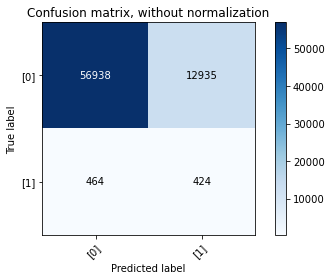

[0.05 0.1  0.05]


In [30]:
import logistic_regression as log_reg
cv = log_reg.log_reg(["data/yaoscores/pos.json", "data/yaoscores/pos2.json"], ["data/yaoscores/neg.json"])
print(cv)